In [46]:
import tensorflow as tf
print(tf.__version__)

2.13.0-rc1


In [47]:
from tensorflow.python.client import device_lib
USE_GPU = False
device_lib.list_local_devices()

2023-06-23 12:48:17.113007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-23 12:48:17.113025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9411432355514000043
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 locality {
   bus_id: 1
 }
 incarnation: 324329365641922361
 physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
 xla_global_id: -1]

In [48]:
import numpy as np
from keras.utils import to_categorical
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# ex) 신경망은 -1 ~ 1 범위에서 잘 동작하므로 0 ~ 255(RGB값) -> 0 ~ 1로 변환
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 단순 0 ~ 9 값을 벡터화
# ex) 0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# ex) 1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
# ...
NUM_CLASSES = 10
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)  


In [49]:
# 인덱스 54 이미지의 (12, 13) 좌표에서 초록색 픽셀값 출력해보기
x_train[54, 12, 13, 1]

0.36862746

In [50]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential([
    Flatten(input_shape=(32, 32, 3)),  # 32x32 크기의 이미지 1장을 1차원 배열화
    Dense(200, activation='relu'),     # Dense(Fully connected), ReLU(입력이 음수이면 0, 양수이면 그대로 출력)
    Dense(150, activation='relu'),
    Dense(10, activation='softmax'),   # softmax(전체 출력 합이 1이 되도록 정규화, 하나의 클래스에 속해야 하는 분류에 사용)
])

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_12 (Dense)            (None, 200)               614600    
                                                                 
 dense_13 (Dense)            (None, 150)               30150     
                                                                 
 dense_14 (Dense)            (None, 10)                1510      
                                                                 
Total params: 646260 (2.47 MB)
Trainable params: 646260 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
from keras.optimizers.legacy import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'])

In [53]:
if USE_GPU:
    # GPU 사용
    print(f'GPU: {tf.test.gpu_device_name()}')
    model.fit(x_train, y_train, batch_size=1024, epochs=10, shuffle=True)
else:
    with tf.device('/device:CPU:0'):
        model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)
# 훈련할 때, accuracy는 어떻게 계산?

Epoch 1/10
  24/1563 [..............................] - ETA: 7s - loss: 2.3208 - accuracy: 0.1562

2023-06-23 12:48:17.848147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 7s 5ms/step - loss: 1.8446 - accuracy: 0.3369
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6647 - accuracy: 0.4053
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5899 - accuracy: 0.4344
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5308 - accuracy: 0.4560
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4885 - accuracy: 0.4705
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4584 - accuracy: 0.4803
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4378 - accuracy: 0.4880
Epoch 8/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4037 - accuracy: 0.4985
Epoch 9/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3835 - accuracy: 0.5071
Epoch 10/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3658 - accurac

In [54]:
model.evaluate(x_test, y_test)

 13/313 [>.............................] - ETA: 2s - loss: 29.5215 - accuracy: 0.0865

2023-06-23 12:49:30.757850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 9ms/step - loss: 27.4958 - accuracy: 0.1151


[27.495830535888672, 0.11509999632835388]

In [55]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

 74/313 [======>.......................] - ETA: 0s

2023-06-23 12:49:33.736826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


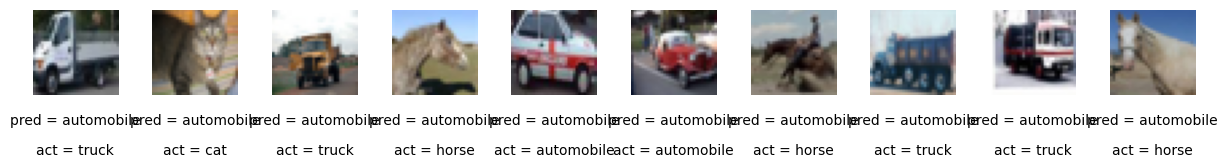

In [56]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, f'pred = {preds_single[idx]}',
            fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, f'act = {actual_single[idx]}',
            fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)